In [26]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist

from transformers import AutoImageProcessor#, TimesformerModel
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
# from timesformer_pytorch import TimeSformer

import random
import threading
import glob

import numpy as np
import wandb
from torch.utils.data import DataLoader
import os
import random
import cv2
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.optim import AdamW
import segmentation_models_pytorch as smp
import numpy as np
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch
from warmup_scheduler import GradualWarmupScheduler
import PIL.Image

PIL.Image.MAX_IMAGE_PIXELS = 933120000

import utils
import models.swin as swin

class CFG:
    # ============== comp exp name =============
    current_dir = './'
    segment_path = './train_scrolls/'
    
    start_idx = 24
    in_chans = 16
    
    size = 224
    tile_size = 224
    stride = tile_size // 8
    
    train_batch_size =  2 # 32
    valid_batch_size = 5
    lr = 1e-4
    num_workers = 8
    # ============== model cfg =============
    scheduler = 'cosine'#, 'linear'
    epochs = 16
    warmup_factor = 10
    
    # Change the size of fragments
    frags_ratio1 = ['frag','re']
    frags_ratio2 = ['202','s4','left']
    ratio1 = 2
    ratio2 = 1
    
    # ============== fold =============
    segments = ['rect5','remaining5'] 
    valid_id = 'remaining5'#20231215151901'
    
    # ============== fixed =============
    min_lr = 1e-7
    weight_decay = 1e-6
    max_grad_norm = 100
    num_workers = 8
    seed = 0
    
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    exp_name = 'pretraining_all'

    outputs_path = f'./outputs/{comp_name}/{exp_name}/'
    model_dir = outputs_path + \
        f'{comp_name}-models/'
        
    # ============== augmentation =============
    train_aug_list = [
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.75),
        # A.ShiftScaleRotate(rotate_limit=360,shift_limit=0.15,scale_limit=0.15,p=0.75),
        # A.OneOf([
        #         A.GaussNoise(var_limit=[10, 50]),
        #         A.GaussianBlur(),
        #         A.MotionBlur(),
        #         ], p=0.4),
        # A.CoarseDropout(max_holes=2, max_width=int(size * 0.2), max_height=int(size * 0.2), 
        #                 mask_fill_value=0, p=0.5),
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
        ToTensorV2(transpose_mask=True),  
    ]
    
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)
    return aug   


# End any existing run (if still active)
if wandb.run is not None:
    wandb.finish()
        
utils.cfg_init(CFG)
torch.set_float32_matmul_precision('medium')

fragment_id = CFG.valid_id
run_slug=f'SWIN_{CFG.segments}_valid={CFG.valid_id}_size={CFG.size}_lr={CFG.lr}_in_chans={CFG.in_chans}'
valid_mask_gt = cv2.imread(f"{CFG.segment_path}{fragment_id}/{fragment_id}_inklabels.png", 0)

if any(sub in fragment_id for sub in CFG.frags_ratio1):
    scale = 1 / CFG.ratio1
    new_w = int(valid_mask_gt.shape[1] * scale)
    new_h = int(valid_mask_gt.shape[0] * scale)
    valid_mask_gt = cv2.resize(valid_mask_gt, (new_w, new_h), interpolation=cv2.INTER_AREA)

elif any(sub in fragment_id for sub in CFG.frags_ratio2):
    scale = 1 / CFG.ratio2
    new_w = int(valid_mask_gt.shape[1] * scale)
    new_h = int(valid_mask_gt.shape[0] * scale)
    valid_mask_gt = cv2.resize(valid_mask_gt, (new_w, new_h), interpolation=cv2.INTER_AREA)
pred_shape=valid_mask_gt.shape

train_images, train_masks, valid_images, valid_masks, valid_xyxys = utils.get_train_valid_dataset(CFG)

print('train_images',train_images[0].shape)
print("Length of train images:", len(train_images))

valid_xyxys = np.stack(valid_xyxys)
train_dataset = swin.TimesformerDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='valid', cfg=CFG))
valid_dataset = swin.TimesformerDataset(
    valid_images, CFG, xyxys=valid_xyxys, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                            batch_size=CFG.train_batch_size,
                            shuffle=True,
                            num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                            )
valid_loader = DataLoader(valid_dataset,
                            batch_size=CFG.valid_batch_size,
                            shuffle=False,
                            num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

print(f"Train loader length: {len(train_loader)}")
print(f"Valid loader length: {len(valid_loader)}")

reading rect5


100%|██████████| 16/16 [00:00<00:00, 126.18it/s]


 Shape of rect5 segment: (1008, 1008, 16)
reading remaining5


100%|██████████| 16/16 [00:01<00:00, 15.52it/s]


 Shape of remaining5 segment: (3696, 2352, 16)
train_images (224, 224, 16)
Length of train images: 440
Train loader length: 220
Valid loader length: 895


# STAT

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstruction(original, reconstructed, sample_idx=0, num_frames=1):
    """
    Visualize original and reconstructed video frames side-by-side.
    
    Args:
        original: Tensor (B, T, C, H, W) original input video batch.
        reconstructed: Tensor (B, T, C, H, W) reconstructed output from model.
        sample_idx: Which sample in batch to visualize.
        num_frames: How many time frames to display.
    """

    orig = original[sample_idx].cpu().numpy()  # (T, C, H, W)
    recon = reconstructed[sample_idx].cpu().detach().numpy()  # (T, C, H, W)
    
    # For visualization, convert channel order from C,H,W to H,W,C and clip to [0,1]
    orig = np.transpose(orig, (0, 2, 3, 1))
    recon = np.transpose(recon, (0, 2, 3, 1))
    orig = np.clip(orig, 0, 1)
    recon = np.clip(recon, 0, 1)

    fig, axs = plt.subplots(2, num_frames, figsize=(num_frames * 3, 6))
    for i in range(num_frames):
        axs[0, i].imshow(orig[i])
        axs[0, i].set_title(f'Original Frame {i}')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(recon[i])
        axs[1, i].set_title(f'Reconstructed Frame {i}')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()
import matplotlib.pyplot as plt
import numpy as np


def visualize_x_masked(x_masked, sample_idx=0, num_frames=4):
    """
    Visualize masked input video frames.
    
    Args:
        x_masked: tensor (B, C, T, H, W)
        sample_idx: which sample in batch to visualize
        num_frames: how many frames to show
    """
    video = x_masked[sample_idx]  # (C, T, H, W)
    print(video.shape)
    C, T, H, W = video.shape

    fig, axs = plt.subplots(1, num_frames, figsize=(num_frames * 3, 3))
    for i in range(num_frames):
        frame = video[:, i, :, :].permute(1, 2, 0).cpu().numpy()  # (H, W, C)
        if C == 3:
            frame = frame.clip(0, 1)  # Assuming normalized video frames
        else:
            frame = frame.squeeze()  # For single-channel

        axs[i].imshow(frame)
        axs[i].axis('off')
        axs[i].set_title(f'Frame {i}')
    plt.show()



In [29]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision.models.video import swin_transformer
from torch.utils.data import DataLoader, Dataset
import numpy as np

class MAEPretrainSwin(pl.LightningModule):
    def __init__(self, lr=1e-4, mask_ratio=0.9, patch_size=16):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = swin_transformer.swin3d_t(weights=None)
        self.encoder.head = nn.Identity()

        # Feature hook (grab feature before classification)
        self.features = None
        self.encoder.features[-1].register_forward_hook(self._hook)

        self.decoder = nn.Sequential(
            nn.Conv3d(768, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(256, 16, kernel_size=1)
        )
        self.criterion = nn.MSELoss()
        self.patch_size = patch_size
        
            # ✅ Add this line
        self.train_loss_history = []


    def _hook(self, module, input, output):
        # Save the last feature map for reconstruction
        self.features = output  # shape: (B, T', H', W', C)

    def patchify(self, x):
        x = x.permute(0,2,1,3,4)
        B, C, T, H, W = x.shape
        # print(x.shape)
        # Ensure patch_size is compatible with input dimensions
        assert T % self.patch_size == 0 and H % self.patch_size == 0 and W % self.patch_size == 0, "Input dimensions must be divisible by patch size"

        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).unfold(4, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, C, -1, self.patch_size, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 1, 3, 4, 5)  # (B, num_patches, C, patch_size, patch_size, patch_size)
        x = x.reshape(B, -1, C * self.patch_size * self.patch_size * self.patch_size)  # (B, num_patches, C * patch_size^3)
        # print('patchify',x.shape)
        return x

    def unpatchify(self, x, original_shape):
        B, num_patches, _ = x.shape
        T, C, H, W = original_shape
        patch_size = self.patch_size
        
        x = x.view(B, num_patches, patch_size, patch_size, patch_size, C)

        x = x.permute(0, 5, 1, 2, 3, 4)  # (B, C, num_patches_T, num_patches_H, num_patches_W, patch_size, patch_size, patch_size)
        x = x.reshape(B, C,2, 14,14)
        # x = x.reshape(B, C, T,x.shape[-1]//2,-1)
        # print('x_unpatch',x.shape)
        return x

    def random_masking(self, x, ratio):
        B, N, D = x.shape  # (B, num_patches, patch_dim)
        len_keep = int(N * (1 - ratio))

        noise = torch.rand(B, N, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]

        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, D))
        return x_masked, ids_keep, ids_shuffle

    def forward(self, x):
        # x shape: (B, 3, T, H, W)
        B, C, T, H, W = x.shape

        # Patchify the input
        x_patched = self.patchify(x)
        # print(x_patched.shape)

        # Apply random masking
        x_masked, ids_keep, ids_shuffle = self.random_masking(x_patched, self.hparams.mask_ratio)
        # print('x_maskd',x_masked.shape)

        # Unpatchify the masked patches
        x_masked = self.unpatchify(x_masked, (C, T, H, W))

        # Run encoder
        _ = self.encoder(x_masked)

        # Hook saved the features
        feat = self.features  # (B, T', H', W', C)
        feat = feat.permute(0, 4, 1, 2, 3)  # → (B, C, T', H', W')

        # Decode
        recon = self.decoder(feat)
        recon = nn.functional.interpolate(recon, size=(T, H, W), mode='trilinear', align_corners=False)

        return recon, x_masked

    def training_step(self, batch, batch_idx):
        x, y = batch  # shape: (B, 3, T, H, W)
        recon, x_masked = self(x)

        # Compute loss
        loss = self.criterion(recon, x)
        self.train_loss_history.append(loss.item())  # ✅ Track loss here
        self.log("train_loss", loss, prog_bar=True, logger=True)
        if batch_idx == 0:
            visualize_reconstruction(x, recon, sample_idx=0, num_frames=2)
            visualize_x_masked(x_masked, sample_idx=0, num_frames=2)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


model = MAEPretrainSwin(patch_size=16)
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='auto',
    log_every_n_steps=20,
)
trainer.fit(model, train_loader)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | encoder   | SwinTransformer3d | 27.9 M | train
1 | decoder   | Sequential        | 5.3 M  | train
2 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total param

Epoch 0:   0%|          | 0/220 [00:00<?, ?it/s] 

RuntimeError: shape '[2, 3, 2, 14, 14]' is invalid for input of size 466944

In [13]:
del model
del trainer
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()


Epoch 0:   0%|          | 0/44 [00:58<?, ?it/s]


12213

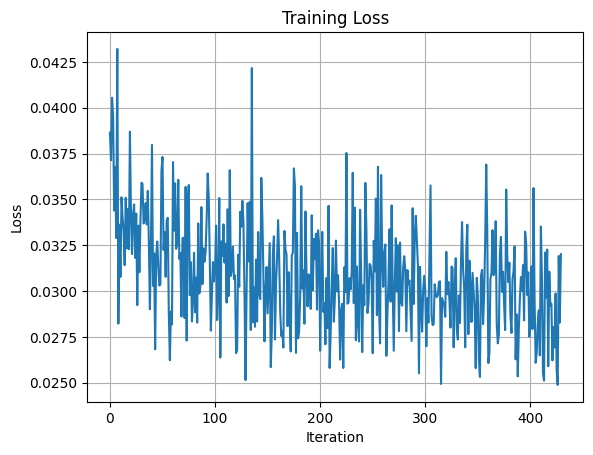

In [22]:
import matplotlib.pyplot as plt
# Plot training loss
plt.plot(model.train_loss_history[10:])
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# assymtIC

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstruction(original, reconstructed, sample_idx=0, num_frames=2):
    """
    Visualize original and reconstructed video frames side-by-side.
    
    Args:
        original: Tensor (B, T, C, H, W) original input video batch.
        reconstructed: Tensor (B, T, C, H, W) reconstructed output from model.
        sample_idx: Which sample in batch to visualize.
        num_frames: How many time frames to display.
    """

    orig = original[sample_idx].cpu().numpy()  # (T, C, H, W)
    recon = reconstructed[sample_idx].cpu().detach().numpy()  # (T, C, H, W)
    
    # For visualization, convert channel order from C,H,W to H,W,C and clip to [0,1]
    orig = np.transpose(orig, (0, 2, 3, 1))
    recon = np.transpose(recon, (0, 2, 3, 1))
    orig = np.clip(orig, 0, 1)
    recon = np.clip(recon, 0, 1)

    fig, axs = plt.subplots(2, num_frames, figsize=(num_frames * 3, 6))
    for i in range(num_frames):
        axs[0, i].imshow(orig[i])
        axs[0, i].set_title(f'Original Frame {i}')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(recon[i])
        axs[1, i].set_title(f'Reconstructed Frame {i}')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()
import matplotlib.pyplot as plt
import numpy as np


def visualize_x_masked(x_masked, sample_idx=0, num_frames=4):
    """
    Visualize masked input video frames.
    
    Args:
        x_masked: tensor (B, C, T, H, W)
        sample_idx: which sample in batch to visualize
        num_frames: how many frames to show
    """
    video = x_masked[sample_idx]  # (C, T, H, W)
    C, T, H, W = video.shape

    fig, axs = plt.subplots(1, num_frames, figsize=(num_frames * 3, 3))
    for i in range(num_frames):
        frame = video[:, i, :, :].permute(1, 2, 0).cpu().numpy()  # (H, W, C)
        if C == 3:
            frame = frame.clip(0, 1)  # Assuming normalized video frames
        else:
            frame = frame.squeeze()  # For single-channel

        axs[i].imshow(frame)
        axs[i].axis('off')
        axs[i].set_title(f'Frame {i}')
    plt.show()



In [24]:
del model
del trainer
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()


Epoch 0:   0%|          | 0/88 [00:33<?, ?it/s]


19617

In [42]:
# from torch.optim import AdamW
# from warmup_scheduler import GradualWarmupScheduler

# import utils

# from transformers import SegformerForSemanticSegmentation
# from torchvision.models.video import swin_transformer
# import albumentations as A
# class MAEPretrainSwin(pl.LightningModule):
#     def __init__(self, lr=1e-4, mask_ratio=4, patch_size=16, embed_dim=768, decoder_dim=512, decoder_layers=4,input_T=16,input_H=224,input_W=224):
#         super().__init__()
#         self.save_hyperparameters()
#         self.encoder = swin_transformer.swin3d_t(weights='KINETICS400_V1')
        
#         self.encoder.head = nn.Identity()
#         self.encoder.features[-1].register_forward_hook(self._hook)

#         self.features = None
#         self.patch_size = patch_size
#         self.criterion = nn.MSELoss()
#         self.train_loss_history = []

#         # Transformer decoder components
#         self.decoder_embed = nn.Linear(embed_dim, decoder_dim)
#         self.decoder_pos_embed = nn.Parameter(torch.randn(1, 1000, decoder_dim))  # Assume max 1000 patches
#         decoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=8, dim_feedforward=2048)
#         self.decoder_transformer = nn.TransformerEncoder(decoder_layer, num_layers=decoder_layers)
#         self.decoder_pred = nn.Linear(decoder_dim, 3 * patch_size**3)  # Output prediction per patch

#         # Mask token for masked patches in decoder
#         self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
#         nn.init.normal_(self.mask_token, std=0.02)

#     def _hook(self, module, input, output):
#         self.features = output  # Save encoder output feature map

#     def patchify(self, x):
#         x = x.permute(0,2,1,3,4)  # (B,C,T,H,W)
#         B, C, T, H, W = x.shape
#         assert T % self.patch_size == 0 and H % self.patch_size == 0 and W % self.patch_size == 0
#         x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).unfold(4, self.patch_size, self.patch_size)
#         x = x.contiguous().view(B, C, -1, self.patch_size, self.patch_size, self.patch_size)
#         x = x.permute(0, 2, 1, 3, 4, 5)  # (B, N, C, ps, ps, ps)
#         x = x.reshape(B, -1, C * self.patch_size**3)
#         return x

#     def unpatchify(self, x, patch_shape):
#         B, N, D = x.shape
#         pt, ph, pw = patch_shape
#         ps = self.patch_size
#         C = D // (ps**3)
#         assert pt * ph * pw == N
#         x = x.view(B, pt, ph, pw, C, ps, ps, ps)
#         x = x.permute(0, 4, 1, 5, 2, 6, 3, 7)
#         x = x.contiguous().view(B, C, pt * ps, ph * ps, pw * ps)
#         return x

#     def tube_masking(self, x, square_size=4):
#         B, N, D = x.shape
#         T, H, W = self.hparams.input_T, self.hparams.input_H, self.hparams.input_W
#         ps = self.patch_size
#         pt, ph, pw = T // ps, H // ps, W // ps
#         num_spatial = ph * pw
#         # assert square_size <= ph and square_size <= pw

#         ids_keep = []
#         for b in range(B):
#             top = torch.randint(0, ph - square_size + 1, (1,))
#             left = torch.randint(0, pw - square_size + 1, (1,))
#             spatial_ids = [(top + i) * pw + (left + j) for i in range(square_size) for j in range(square_size)]

#             tube_indices = []
#             for t in range(pt):
#                 for idx in spatial_ids:
#                     tube_indices.append(t * num_spatial + idx)

#             ids_keep.append(torch.tensor(tube_indices, device=x.device))
#         ids_keep = torch.stack(ids_keep, dim=0)  # (B, kept_patches)
#         x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

#         num_total = x.shape[1]
#         num_keep = ids_keep.shape[1]
#         mask_ratio_actual = 1 - (num_keep / num_total)
#         # print(f"Actual mask ratio: {mask_ratio_actual:.4f} ({num_keep}/{num_total} patches kept)")
#         return x_masked, ids_keep, None

#     def forward(self, x):
#         B, T, C, H, W = x.shape

#         # 1. Patchify input video
#         x_patched = self.patchify(x)  # (B, N, D)
#         N = x_patched.shape[1]

#         # 2. Mask patches, keep a tube of patches visible to encoder
#         x_masked, ids_keep, _ = self.tube_masking(x_patched, square_size=model.hparams.mask_ratio)  # (B, n_visible, D)
#         ids_keep = ids_keep.long()

#         # Calculate masked patch indices
#         all_ids = torch.arange(N, device=x.device).unsqueeze(0).expand(B, -1)  # (B, N)
#         mask = torch.ones_like(all_ids, dtype=torch.bool)
#         mask.scatter_(1, ids_keep, False)
#         ids_masked = all_ids[mask].view(B, -1)

#         # 3. Unpatchify visible patches to video for encoder
#         pt, ph, pw = T // self.patch_size, H // self.patch_size, W // self.patch_size
#         # We know the tube shape is (pt, square_size, square_size)
#         x_masked_video = self.unpatchify(x_masked, (pt, model.hparams.mask_ratio, model.hparams.mask_ratio))  # (B, C, T, H_mask, W_mask)

#         # 4. Encoder forward on masked video
#         _ = self.encoder(x_masked_video)
#         feat = self.features  # (B, T', H', W', C)
#         feat = feat.permute(0, 4, 1, 2, 3)  # (B, C, T', H', W')
#         feat = F.interpolate(feat, size=(pt, model.hparams.mask_ratio, model.hparams.mask_ratio), mode='trilinear', align_corners=False)
#         feat = feat.flatten(2).transpose(1, 2)  # (B, n_visible, embed_dim)

#         # 5. Embed encoder features to decoder_dim
#         x_vis = self.decoder_embed(feat)  # (B, n_visible, decoder_dim)

#         # 6. Prepare mask tokens for masked patches
#         mask_tokens = self.mask_token.expand(B, ids_masked.shape[1], -1)  # (B, n_masked, decoder_dim)

#         # 7. Create full sequence tensor for decoder input
#         x_dec = torch.zeros(B, N, x_vis.shape[2], device=x.device, dtype=x_vis.dtype)
#         x_dec.scatter_(1, ids_keep.unsqueeze(-1).expand(-1, -1, x_vis.shape[2]), x_vis)
#         x_dec.scatter_(1, ids_masked.unsqueeze(-1).expand(-1, -1, x_vis.shape[2]), mask_tokens)

#         # 8. Add positional embedding
#         pos_embed = self.decoder_pos_embed[:, :N, :]
#         x_dec = x_dec + pos_embed

#         # 9. Decode full sequence
#         x_dec = self.decoder_transformer(x_dec)
#         # print(x_dec.shape)
#         pred = self.decoder_pred(x_dec)  # (B, N, patch_dim)
        

#         # 10. Compute reconstruction loss only on masked patches (in training_step)
#         # 11. Unpatchify pred to video
#         recon = self.unpatchify(pred, (pt, ph, pw))  # (B, C, T, H, W)
#         recon = recon.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)

#         return recon, x_masked_video, mask, ids_masked, pred, x_patched

#     def training_step(self, batch, batch_idx):
#         x, y = batch  # (B, 3, T, H, W)
#         recon, x_masked, mask, ids_masked, pred, target = self(x)

#         # Compute loss only on masked patches
#         # We want pred and target only on masked patches
#         loss = self.criterion(pred[mask], target[mask])
#         self.train_loss_history.append(loss.item())
#         self.train_loss_history.append(loss.item())  # ✅ Track loss here
#         self.log("train_loss", loss, prog_bar=True, logger=True)
#         # Visualize first batch, first 4 frames (optional: only on first batch)
#         # if batch_idx == 0:
#         #     visualize_reconstruction(x, recon, sample_idx=0, num_frames=4)
#         #     visualize_x_masked(x_masked, sample_idx=0, num_frames=4)

#         return loss

#     def configure_optimizers(self):
#         return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


# # -----------------------------
# if __name__ == "__main__":

#     model = MAEPretrainSwin(patch_size=16)
#     trainer = pl.Trainer(
#         max_epochs=50,
#         accelerator='auto',
#         log_every_n_steps=20,
#     )
#     trainer.fit(model, train_loader)
from torch.optim import AdamW
from warmup_scheduler import GradualWarmupScheduler

import utils

from transformers import SegformerForSemanticSegmentation
from torchvision.models.video import swin_transformer
import albumentations as A
class MAEPretrainSwin(pl.LightningModule):
    def __init__(self, lr=1e-4, mask_ratio=4, patch_size=16, embed_dim=768, decoder_dim=512, decoder_layers=2,input_T=16,input_H=224,input_W=224):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = swin_transformer.swin3d_t(weights='KINETICS400_V1')
        
        self.encoder.head = nn.Identity()
        self.encoder.features[-1].register_forward_hook(self._hook)

        self.features = None
        self.patch_size = patch_size
        self.criterion = nn.MSELoss()
        self.train_loss_history = []

        # Transformer decoder components
        self.decoder_embed = nn.Linear(embed_dim, decoder_dim)
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, 1000, decoder_dim))  # Assume max 1000 patches
        decoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=8, dim_feedforward=2048)
        self.decoder_transformer = nn.TransformerEncoder(decoder_layer, num_layers=decoder_layers)
        self.decoder_pred = nn.Linear(decoder_dim, 3 * patch_size**3)  # Output prediction per patch

        # Mask token for masked patches in decoder
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        nn.init.normal_(self.mask_token, std=0.02)

    def _hook(self, module, input, output):
        self.features = output  # Save encoder output feature map

    def patchify(self, x):
        x = x.permute(0,2,1,3,4)  # (B,C,T,H,W)
        B, C, T, H, W = x.shape
        assert T % self.patch_size == 0 and H % self.patch_size == 0 and W % self.patch_size == 0
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).unfold(4, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, C, -1, self.patch_size, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 1, 3, 4, 5)  # (B, N, C, ps, ps, ps)
        x = x.reshape(B, -1, C * self.patch_size**3)
        return x

    def unpatchify(self, x, patch_shape):
        B, N, D = x.shape
        pt, ph, pw = patch_shape
        ps = self.patch_size
        C = D // (ps**3)
        assert pt * ph * pw == N
        x = x.view(B, pt, ph, pw, C, ps, ps, ps)
        x = x.permute(0, 4, 1, 5, 2, 6, 3, 7)
        x = x.contiguous().view(B, C, pt * ps, ph * ps, pw * ps)
        return x

    def tube_masking(self, x, square_size=4):
        B, N, D = x.shape
        T, H, W = self.hparams.input_T, self.hparams.input_H, self.hparams.input_W
        ps = self.patch_size
        pt, ph, pw = T // ps, H // ps, W // ps
        num_spatial = ph * pw
        assert square_size <= ph and square_size <= pw

        ids_keep = []
        for b in range(B):
            top = torch.randint(0, ph - square_size + 1, (1,))
            left = torch.randint(0, pw - square_size + 1, (1,))
            spatial_ids = [(top + i) * pw + (left + j) for i in range(square_size) for j in range(square_size)]

            tube_indices = []
            for t in range(pt):
                for idx in spatial_ids:
                    tube_indices.append(t * num_spatial + idx)

            ids_keep.append(torch.tensor(tube_indices, device=x.device))
        ids_keep = torch.stack(ids_keep, dim=0)  # (B, kept_patches)
        x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).expand(-1, -1, D))

        num_total = x.shape[1]
        num_keep = ids_keep.shape[1]
        mask_ratio_actual = 1 - (num_keep / num_total)
        # print(f"Actual mask ratio: {mask_ratio_actual:.4f} ({num_keep}/{num_total} patches kept)")
        return x_masked, ids_keep, None

    def forward(self, x):
        B, T, C, H, W = x.shape

        # 1. Patchify input video
        x_patched = self.patchify(x)  # (B, N, D)
        N = x_patched.shape[1]
        print(N)

        # 2. Mask patches, keep a tube of patches visible to encoder
        x_masked, ids_keep, _ = self.tube_masking(x_patched, square_size=model.hparams.mask_ratio)  # (B, n_visible, D)
        ids_keep = ids_keep.long()

        # Calculate masked patch indices
        all_ids = torch.arange(N, device=x.device).unsqueeze(0).expand(B, -1)  # (B, N)
        mask = torch.ones_like(all_ids, dtype=torch.bool)
        mask.scatter_(1, ids_keep, False)
        ids_masked = all_ids[mask].view(B, -1)

        # 3. Unpatchify visible patches to video for encoder
        pt, ph, pw = T // self.patch_size, H // self.patch_size, W // self.patch_size
        # We know the tube shape is (pt, square_size, square_size)
        x_masked_video = self.unpatchify(x_masked, (pt, model.hparams.mask_ratio, model.hparams.mask_ratio))  # (B, C, T, H_mask, W_mask)

        # 4. Encoder forward on masked video
        _ = self.encoder(x_masked_video)
        feat = self.features  # (B, T', H', W', C)
        feat = feat.permute(0, 4, 1, 2, 3)  # (B, C, T', H', W')
        feat = F.interpolate(feat, size=(pt, model.hparams.mask_ratio, model.hparams.mask_ratio), mode='trilinear', align_corners=False)
        feat = feat.flatten(2).transpose(1, 2)  # (B, n_visible, embed_dim)

        # 5. Embed encoder features to decoder_dim
        x_vis = self.decoder_embed(feat)  # (B, n_visible, decoder_dim)

        # 6. Prepare mask tokens for masked patches
        mask_tokens = self.mask_token.expand(B, ids_masked.shape[1], -1)  # (B, n_masked, decoder_dim)

        # 7. Create full sequence tensor for decoder input
        x_dec = torch.zeros(B, N, x_vis.shape[2], device=x.device, dtype=x_vis.dtype)
        x_dec.scatter_(1, ids_keep.unsqueeze(-1).expand(-1, -1, x_vis.shape[2]), x_vis)
        x_dec.scatter_(1, ids_masked.unsqueeze(-1).expand(-1, -1, x_vis.shape[2]), mask_tokens)

        # 8. Add positional embedding
        pos_embed = self.decoder_pos_embed[:, :N, :]
        x_dec = x_dec + pos_embed

        # 9. Decode full sequence
        x_dec = self.decoder_transformer(x_dec)
        pred = self.decoder_pred(x_dec)  # (B, N, patch_dim)
        # pred.reshape(B, C, T, H, W)
        # print(pred.shape)
        # 10. Compute reconstruction loss only on masked patches (in training_step)
        # 11. Unpatchify pred to video
        recon = self.unpatchify(pred, (pt, ph, pw))  # (B, C, T, H, W)
        recon = recon.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)
        print(recon.shape)

        return recon, x_masked_video, mask, ids_masked, pred, x_patched

    def training_step(self, batch, batch_idx):
        x, y = batch  # (B, 3, T, H, W)
        
        recon, x_masked, mask, ids_masked, pred, target = self(x)

        # Compute loss only on masked patches
        # We want pred and target only on masked patches
        loss = self.criterion(pred, target)
        self.train_loss_history.append(loss.item())
        self.train_loss_history.append(loss.item())  # ✅ Track loss here
        self.log("train_loss", loss, prog_bar=True, logger=True)
        # Visualize first batch, first 4 frames (optional: only on first batch)
        # if batch_idx == 0:
            # visualize_reconstruction(x, recon, sample_idx=2, num_frames=2)
            # visualize_x_masked(x_masked, sample_idx=8, num_frames=2)

        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


# -----------------------------
if __name__ == "__main__":

    model = MAEPretrainSwin(patch_size=16)
    trainer = pl.Trainer(
        max_epochs=50,
        accelerator='auto',
        log_every_n_steps=20,
    )
    trainer.fit(model, train_loader)

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                | Type               | Params | Mode 
--------------------------------

Epoch 0:   0%|          | 0/220 [00:00<?, ?it/s] 196
torch.Size([2, 16, 3, 224, 224])
Epoch 0:   0%|          | 1/220 [00:00<00:42,  5.18it/s, v_num=304, train_loss=0.502]196
torch.Size([2, 16, 3, 224, 224])
Epoch 0:   1%|          | 2/220 [00:00<00:28,  7.75it/s, v_num=304, train_loss=0.485]196
torch.Size([2, 16, 3, 224, 224])
Epoch 0:   1%|▏         | 3/220 [00:00<00:22,  9.44it/s, v_num=304, train_loss=0.468]196
torch.Size([2, 16, 3, 224, 224])
Epoch 0:   2%|▏         | 4/220 [00:00<00:20, 10.51it/s, v_num=304, train_loss=0.455]196
torch.Size([2, 16, 3, 224, 224])
Epoch 0:   2%|▏         | 5/220 [00:00<00:18, 11.45it/s, v_num=304, train_loss=0.429]196
torch.Size([2, 16, 3, 224, 224])
Epoch 0:   3%|▎         | 6/220 [00:00<00:17, 12.19it/s, v_num=304, train_loss=0.399]196
torch.Size([2, 16, 3, 224, 224])
Epoch 0:   3%|▎         | 7/220 [00:00<00:16, 12.79it/s, v_num=304, train_loss=0.380]196
torch.Size([2, 16, 3, 224, 224])
Epoch 0:   4%|▎         | 8/220 [00:00<00:15, 13.29it/s, v_n


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

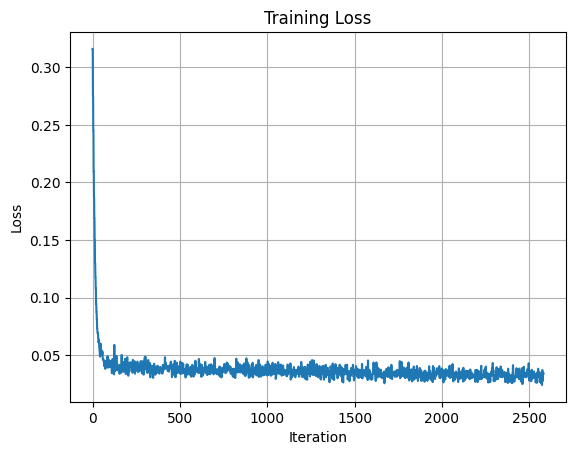

In [8]:
import matplotlib.pyplot as plt
# Plot training loss
plt.plot(model.train_loss_history[10:])
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [8]:
del model
del trainer
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()


192691

In [32]:
del model
del trainer
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()


Epoch 0:   0%|          | 0/44 [01:14<?, ?it/s]


23852

In [19]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision.models.video import swin_transformer
from torch.utils.data import DataLoader, Dataset
import numpy as np

class MAEPretrainSwin(pl.LightningModule):
    def __init__(self, lr=1e-4, mask_ratio=0.5):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = swin_transformer.swin3d_t(weights=None)
        self.encoder.head = nn.Identity()

        # Feature hook (grab feature before classification)
        self.features = None
        self.encoder.features[-1].register_forward_hook(self._hook)

        self.decoder = nn.Sequential(
            nn.Conv3d(768, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(256, 16, kernel_size=1)
        )

        self.criterion = nn.MSELoss()
                
            # ✅ Add this line
        self.train_loss_history = []

    def _hook(self, module, input, output):
        # Save the last feature map for reconstruction
        self.features = output  # shape: (B, T', H', W', C)

    def forward(self, x):
        # x shape: (B, 3, T, H, W)
        B, C, T, H, W = x.shape
        # Apply masking
        mask = torch.rand(B, 1, T, H, W, device=x.device) < self.hparams.mask_ratio
        x_masked = x.clone()
        x_masked[mask.expand_as(x_masked)] = 0.0  # zero out masked regions
        # Run encoder (Swin3D expects full input, so this is soft-masking)
        # print(x.shape)
        x = x.permute(0,2,1,3,4)
        _ = self.encoder(x)
        

        # Hook saved the features
        feat = self.features  # (B, T', H', W', C)
        feat = feat.permute(0, 4, 1, 2, 3)  # → (B, C, T', H', W')
        # Decode
        recon = self.decoder(feat)
        # print(recon.shape)
        recon = nn.functional.interpolate(recon, size=(T, H, W), mode='trilinear', align_corners=False)

        return recon, mask

    def training_step(self, batch, batch_idx):
        x,y = batch  # shape: (B, 3, T, H, W)
        recon, mask = self(x)

        # Compute loss only on masked parts
        loss = self.criterion(recon[mask.expand_as(x)], x[mask.expand_as(x)])
        self.train_loss_history.append(loss.item())  # ✅ Track loss here

        self.log("train_loss", loss, prog_bar=True, logger=True)

        return loss


    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

    def random_masking(self, x, ratio):
        B, T, C, H, W = x.shape
        x = x.view(B, T * H * W, C)
        N = x.shape[1]
        len_keep = int(N * (1 - ratio))

        noise = torch.rand(B, N, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]

        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, C))
        return x_masked, ids_shuffle

# Training Script
# -----------------------------
if __name__ == "__main__":

    model = MAEPretrainSwin()

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='auto',
        log_every_n_steps=20,
    )

    trainer.fit(model, train_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | encoder   | SwinTransformer3d | 27.9 M | train
1 | decoder   | Sequential        | 5.3 M  | train
2 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total param

Epoch 7:  11%|█▏        | 5/44 [00:05<00:40,  0.97it/s, v_num=122, train_loss=0.0254] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

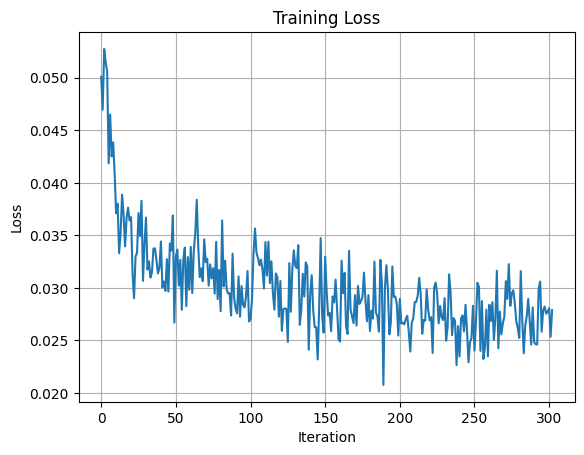

In [20]:
import matplotlib.pyplot as plt
# Plot training loss
plt.plot(model.train_loss_history[10:])
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
# import torch
# import torch.nn as nn
# import pytorch_lightning as pl
# from torchvision.models.video import swin_transformer
# from torch.utils.data import DataLoader, Dataset
# import numpy as np

# class MAEPretrainSwin(pl.LightningModule):
#     def __init__(self, lr=1e-4, mask_ratio=0.9):
#         super().__init__()
#         self.save_hyperparameters()
#         self.encoder = swin_transformer.swin3d_t(weights=None)
#         self.encoder.head = nn.Identity()

#         # Feature hook (grab feature before classification)
#         self.features = None
#         self.encoder.features[-1].register_forward_hook(self._hook)

#         self.decoder = nn.Sequential(
#             nn.Conv3d(768, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv3d(256, 16, kernel_size=1)
#         )
#         self.criterion = nn.MSELoss()

#     def _hook(self, module, input, output):
#         # Save the last feature map for reconstruction
#         self.features = output  # shape: (B, T', H', W', C)

#     def random_masking(self, x, ratio):
#         B, C, T, H, W = x.shape
#         x = x.permute(0, 2, 3, 4, 1)  # (B, T, H, W, C)
#         x = x.reshape(B, T * H * W, C)  # (B, N, C)
#         N = x.shape[1]
#         len_keep = int(N * (1 - ratio))

#         noise = torch.rand(B, N, device=x.device)
#         ids_shuffle = torch.argsort(noise, dim=1)
#         ids_keep = ids_shuffle[:, :len_keep]

#         x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, C))
#         return x_masked, ids_keep, ids_shuffle

#     def forward(self, x):
#         # x shape: (B, 3, T, H, W)
#         B, C, T, H, W = x.shape

#         # Apply random masking
#         x_masked, ids_keep, ids_shuffle = self.random_masking(x, self.hparams.mask_ratio)
#         x_masked = x_masked.view(B, T, H, W, C).permute(0, 4, 1, 2, 3)  # (B, C, T, H, W)

#         # Run encoder
#         _ = self.encoder(x_masked)

#         # Hook saved the features
#         feat = self.features  # (B, T', H', W', C)
#         feat = feat.permute(0, 4, 1, 2, 3)  # → (B, C, T', H', W')

#         # Decode
#         recon = self.decoder(feat)
#         recon = nn.functional.interpolate(recon, size=(T, H, W), mode='trilinear', align_corners=False)

#         return recon, x_masked, ids_keep, ids_shuffle

#     def training_step(self, batch, batch_idx):
#         x, y = batch  # shape: (B, 3, T, H, W)
#         recon, x_masked, ids_keep, ids_shuffle = self(x)

#         # Compute loss only on masked parts
#         loss = self.criterion(recon, x)
#         self.log("train_loss", loss, prog_bar=True, logger=True)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

# # Training Script
# # -----------------------------
# if __name__ == "__main__":
#     # dataset = DummyVideoDataset(num_samples=100, frames=16)
#     # dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)
#     model = MAEPretrainSwin()
#     trainer = pl.Trainer(
#         max_epochs=10,
#         accelerator='auto',
#         log_every_n_steps=20,
#     )
#     trainer.fit(model, train_loader)


Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | encoder   | SwinTransformer3d | 27.9 M | train
1 | decoder   | Sequential        | 5.3 M  | train
2 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Tot

Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s] 

RuntimeError: shape '[2, 16, 32, 32, 3]' is invalid for input of size 9828

# NOT SYMMTIC

In [19]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Dummy Video Dataset
# ---------------------------
class DummyVideoDataset(Dataset):
    def __init__(self, num_samples=10, channels=3, frames=16, height=224, width=224):
        self.num_samples = num_samples
        self.shape = (channels, frames, height, width)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        video = torch.rand(self.shape)
        return video


# ---------------------------
# Patch Embedding for 3D (Video)
# ---------------------------
# class PatchEmbed3D(nn.Module):
#     def __init__(self, patch_size=(2, 16, 16), in_chans=3, embed_dim=768):
#         super().__init__()
#         self.proj = nn.Conv3d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
#         self.patch_size = patch_size

#     def forward(self, x):
#         # x: (B, 3, T, H, W)
#         x = self.proj(x)  # (B, D, T', H', W')
#         x = x.flatten(2).transpose(1, 2)  # (B, N_patches, embed_dim)
#         return x
class PatchEmbed3D(nn.Module):
    def __init__(self, patch_size=(2, 16, 16), in_chans=3, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv3d(
            in_chans, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, T', H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, N, embed_dim)
        return x



# ---------------------------
# MAE Lightning Module
# ---------------------------
class MAEPretrainVideo(pl.LightningModule):
    def __init__(self, lr=1e-4, mask_ratio=0.75, patch_size=(2, 16, 16), embed_dim=768):
        super().__init__()
        self.save_hyperparameters()

        self.patch_embed = PatchEmbed3D(patch_size=patch_size, in_chans=3, embed_dim=embed_dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8),
            num_layers=6
        )
        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.normal_(self.mask_token, std=0.02)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, patch_size[0] * patch_size[1] * patch_size[2] * 3),
        )

        self.criterion = nn.MSELoss()
        self.patch_dim = patch_size[0] * patch_size[1] * patch_size[2] * 3

    def random_masking(self, x, mask_ratio):
        B, N, D = x.shape
        len_keep = int(N * (1 - mask_ratio))
        noise = torch.rand(B, N, device=x.device)

        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        ids_keep = ids_shuffle[:, :len_keep]
        x_visible = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, D))

        return x_visible, ids_keep, ids_restore

    def forward(self, x):
        # Step 1: Patchify
        x_patches = self.patch_embed(x)  # (B, N, D)
        print(x_patches.shape)

        # Step 2: Random Masking
        x_visible, ids_keep, ids_restore = self.random_masking(x_patches, self.hparams.mask_ratio)
        print(x_visible.shape)
        # Step 3: Encode only visible patches
        x_encoded = self.encoder(x_visible)  # (B, N_vis, D)
        print(x_encoded.shape)
        # Step 4: Add mask tokens
        B, N, D = x_patches.shape
        mask_tokens = self.mask_token.expand(B, N - x_encoded.shape[1], -1)
        x_combined = torch.cat([x_encoded, mask_tokens], dim=1)

        # Step 5: Unshuffle to original order
        x_decoder_input = torch.gather(x_combined, dim=1, index=ids_restore.unsqueeze(-1).expand(-1, -1, D))

        # Step 6: Decode to patch pixels
        x_rec = self.decoder(x_decoder_input)  # (B, N, patch_volume)
        return x_rec, x_patches, ids_restore

    def training_step(self, batch, batch_idx):
        x = batch  # (B, 3, T, H, W)
        rec, target, _ = self(x)

        loss = self.criterion(rec, target)
        self.log("train_loss", loss, prog_bar=True)
        print(f"Step {batch_idx}: train_loss = {loss.item():.6f}")
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


# ---------------------------
# Train the Model
# ---------------------------
if __name__ == "__main__":
    dataset = DummyVideoDataset(num_samples=100, frames=16)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

    model = MAEPretrainVideo(
        lr=1e-4,
        mask_ratio=0.75,
        patch_size=(2, 16, 16),  # (T, H, W)
        embed_dim=768
    )

    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='auto',
        log_every_n_steps=1
    )

    trainer.fit(model, dataloader)


/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type               | Params | Mode 
---------------------------------------

Epoch 0:   0%|          | 0/50 [00:00<?, ?it/s] 

/home/ubuntu/miniconda3/envs/dion/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2, 1568, 768])) that is different to the input size (torch.Size([2, 1568, 1536])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([2, 1568, 768])
torch.Size([2, 392, 768])
torch.Size([2, 392, 768])


RuntimeError: The size of tensor a (1536) must match the size of tensor b (768) at non-singleton dimension 2

In [20]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import swin_transformer


# ---------------------------
# Dummy Dataset
# ---------------------------
class DummyVideoDataset(Dataset):
    def __init__(self, num_samples=100, channels=3, frames=16, height=224, width=224):
        self.num_samples = num_samples
        self.shape = (channels, frames, height, width)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        video = torch.rand(self.shape)
        return video


# ---------------------------
# MAE + Swin3D Tube Encoder
# ---------------------------
class MAEWithSwin3D(pl.LightningModule):
    def __init__(self, lr=1e-4, patch_size=(2, 16, 16), mask_ratio=0.75):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = swin_transformer.swin3d_t(weights=None)
        self.encoder.head = nn.Identity()  # remove classifier
        self.embed_dim = 768  # swin3d_t output

        # Tube (patch) size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.patch_dim = patch_size[0] * patch_size[1] * patch_size[2] * 3  # pixel dim of tube

        # Mask token
        self.mask_token = nn.Parameter(torch.zeros(1, self.embed_dim))
        nn.init.normal_(self.mask_token, std=0.02)

        # Decoder: embed → pixel patch
        self.decoder = nn.Sequential(
            nn.Linear(self.embed_dim, self.patch_dim)
        )

        self.criterion = nn.MSELoss()

    def patchify(self, video):
        B, C, T, H, W = video.shape
        pt, ph, pw = self.patch_size
        assert T % pt == 0 and H % ph == 0 and W % pw == 0

        video = video.view(
            B, C,
            T // pt, pt,
            H // ph, ph,
            W // pw, pw
        )  # (B, C, T', pt, H', ph, W', pw)

        video = video.permute(0, 2, 4, 6, 1, 3, 5, 7)  # (B, T', H', W', C, pt, ph, pw)
        patches = video.reshape(B, -1, C, pt, ph, pw)  # (B, N, C, pt, ph, pw)
        return patches

    def unpatchify(self, patches, original_shape):
        B, N, C, pt, ph, pw = patches.shape
        _, _, T, H, W = original_shape
        T_ = T // pt
        H_ = H // ph
        W_ = W // pw

        patches = patches.view(B, T_, H_, W_, C, pt, ph, pw)
        patches = patches.permute(0, 4, 1, 5, 2, 6, 3, 7)
        video = patches.reshape(B, C, T, H, W)
        return video

    def random_masking(self, N, device):
        len_keep = int(N * (1 - self.mask_ratio))
        noise = torch.rand(N, device=device)
        ids_shuffle = torch.argsort(noise)
        ids_keep = ids_shuffle[:len_keep]
        ids_mask = ids_shuffle[len_keep:]
        return ids_keep, ids_mask

    def forward(self, x):
        B, C, T, H, W = x.shape
        patches = self.patchify(x)  # (B, N, C, pt, ph, pw)
        B, N, C, pt, ph, pw = patches.shape

        rec_patches = torch.zeros(B, N, C, pt, ph, pw, device=x.device)
        mask_flags = torch.zeros(B, N, device=x.device)

        for b in range(B):
            ids_keep, ids_mask = self.random_masking(N, x.device)
            visible_patches = patches[b, ids_keep]  # (N_vis, C, pt, ph, pw)

            # Encode each visible patch with Swin3D
            vis_recon = []
            for tube in visible_patches:
                tube = tube.unsqueeze(0)  # (1, C, pt, ph, pw)
                emb = self.encoder(tube)  # (1, embed_dim)
                rec = self.decoder(emb)  # (1, patch_dim)
                rec = rec.view(C, pt, ph, pw)
                vis_recon.append(rec)

            vis_recon = torch.stack(vis_recon)  # (N_vis, C, pt, ph, pw)
            rec_patches[b, ids_mask] = patches[b, ids_mask]  # keep ground truth
            rec_patches[b, ids_keep] = vis_recon  # set recon
            mask_flags[b, ids_mask] = 1  # mark for loss

        return rec_patches, patches, mask_flags

    def training_step(self, batch, batch_idx):
        x = batch  # (B, 3, T, H, W)
        recon_patches, target_patches, mask_flags = self(x)

        # Compute loss only on masked patches
        B, N = mask_flags.shape
        loss = 0
        count = 0
        for b in range(B):
            mask = mask_flags[b] == 1
            if mask.sum() == 0:
                continue
            loss += self.criterion(
                recon_patches[b, mask], target_patches[b, mask]
            )
            count += 1
        loss = loss / max(count, 1)
        self.log("train_loss", loss)
        print(f"Step {batch_idx}: train_loss = {loss.item():.6f}")
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


# ---------------------------
# Train Script
# ---------------------------
if __name__ == "__main__":
    dataset = DummyVideoDataset(num_samples=100, frames=16)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

    model = MAEWithSwin3D(
        lr=1e-4,
        patch_size=(2, 16, 16),  # time, height, width
        mask_ratio=0.75
    )

    trainer = pl.Trainer(
        max_epochs=2,
        accelerator='auto',
        log_every_n_steps=1
    )

    trainer.fit(model, dataloader)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | encoder      | SwinTransformer3d | 27.9 M | train
1 | decoder      | Sequential        | 1.2 M  | train
2 | criterion    | MSELoss           | 0      | train
  | other params | n/a               | 768    | n/a  
-----------------------------------------------------------
29.0 M 

Epoch 0:   0%|          | 0/50 [02:37<?, ?it/s]
Step 0: train_loss = 0.000000



Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# HERE

In [43]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision.models.video import swin_transformer
from torch.utils.data import DataLoader, Dataset
import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    current_dir = './'
    segment_path = './train_scrolls/'
    
    start_idx = 24
    in_chans = 16
    
    size = 224
    tile_size = 224
    stride = tile_size // 8 
    
    train_batch_size =  10 # 32
    valid_batch_size = 10
    
    lr = 1e-4
    num_workers = 8
    # ============== model cfg =============
    scheduler = 'linear' # 'cosine', 'linear'
    epochs = 30
    warmup_factor = 10
    
    # Size of fragments
    frags_ratio1 = ["rem",'rect','frag']
    frags_ratio2 = ['nothing']
    ratio1 = 2
    ratio2 = 1
    
    # ============== fold =============
    segments = ['frag5',"rect5"] 
    valid_id = 'frag5'
    # ============== fixed =============
    min_lr = 1e-7
    weight_decay = 1e-6
    max_grad_norm = 100
    num_workers = 8
    seed = 0
    
        # ============== augmentation =============
    train_aug_list = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(rotate_limit=360,shift_limit=0.15,scale_limit=0.15,p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.CoarseDropout(max_holes=2, max_width=int(size * 0.2), max_height=int(size * 0.2), 
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),  
    ]

train_images, train_masks, valid_images, valid_masks, valid_xyxys = utils.get_train_valid_dataset(CFG)

reading frag5


100%|██████████| 16/16 [00:01<00:00, 11.59it/s]


 Shape of frag5 segment: (3696, 2352, 16)
(3696, 2352)


In [44]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)
    return aug  
from models import swin
train_dataset = swin.TimesformerDataset(
    valid_images[:100], CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                            batch_size=CFG.train_batch_size,
                            shuffle=True,
                            num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                            )

In [ ]:
# class DummyVideoDataset(Dataset):
#     def __init__(self, num_samples=10, channels=3, frames=16, height=224, width=224):
#         self.num_samples = num_samples
#         self.shape = (channels, frames, height, width)

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         video = torch.rand(self.shape)  # (C, T, H, W)
#         return video

def mask_video_patches(x, patch_size=(2,16,16), mask_ratio=0.75):
    B, C, T, H, W = x.shape
    pt, ph, pw = patch_size
    assert T % pt == 0 and H % ph == 0 and W % pw == 0, "Video must divide evenly by patch size"
    nt, nh, nw = T // pt, H // ph, W // pw
    num_patches = nt * nh * nw
    len_keep = int(num_patches * (1 - mask_ratio))

    noise = torch.rand(B, num_patches, device=x.device)
    ids_shuffle = torch.argsort(noise, dim=1)
    ids_keep = ids_shuffle[:, :len_keep]

    mask = torch.zeros(B, num_patches, device=x.device)
    mask.scatter_(1, ids_keep, 1)

    mask = mask.view(B, nt, nh, nw, 1, 1, 1).expand(-1, -1, -1, -1, pt, ph, pw)
    mask = mask.reshape(B, 1, T, H, W)
    x_masked = x * mask
    return x_masked

class MAEPretrainSwin(pl.LightningModule):
    def __init__(self, lr=1e-5, mask_ratio=0.75):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = swin_transformer.swin3d_t(weights="KINETICS400_V1")
        self.encoder.head = nn.Identity()

        self.features = None
        self.encoder.features[-1].register_forward_hook(self._hook)

        self.decoder = nn.Sequential(
            nn.Conv3d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(256, 3, kernel_size=1)
        )

        self.criterion = nn.MSELoss()

    def _hook(self, module, input, output):
        self.features = output  # (B, T', H', W', C)

    def forward(self, x):
        x_masked = mask_video_patches(x, patch_size=(2,16,16), mask_ratio=self.hparams.mask_ratio)
        _ = self.encoder(x_masked)
        feat = self.features.permute(0, 4, 1, 2, 3)  # (B, C, T', H', W')
        recon = self.decoder(feat)
        recon = nn.functional.interpolate(recon, size=x.shape[2:], mode='trilinear', align_corners=False)
        return recon

    def training_step(self, batch, batch_idx):
        x = batch  # (B, 3, T, H, W)
        recon = self(x)
        loss = self.criterion(recon, x)
        print(f"Epoch {self.current_epoch} | Step {batch_idx} | Loss: {loss.item():.4f}")
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

if __name__ == "__main__":
    dataset = train_dataset#DummyVideoDataset(num_samples=5)  # Small set to test overfitting
    dataloader = train_loader#DataLoader(dataset, batch_size=1, shuffle=True)

    model = MAEPretrainSwin(mask_ratio=0.)

    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        logger=False,
        enable_checkpointing=False,
    )

    trainer.fit(model, dataloader)


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | encoder   | SwinTransformer3d | 27.9 M | train
1 | decoder   | Sequential        | 2.7 M  | train
2 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
30.5 M    Trainable params
0         Non-trainable params
30.5 M    Total params
122.023   Total estimated model params size (MB)
183       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s] 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [16]:
import torch
from transformers import AutoImageProcessor, TimesformerModel
import torchvision.transforms as T

# Convert to PIL and then to 3 channels
pil_transform = T.Compose([
    T.ToPILImage(),                    # convert (C, H, W) to PIL
    T.Grayscale(num_output_channels=3),  # convert to 3 channels
])

# from transformers import TimeSformerModel, TimeSformerConfig, TimeSformerImageProcessor
import numpy as np

# Load pretrained TimeSformer
model = TimesformerModel.from_pretrained("facebook/timesformer-hr-finetuned-k600")
processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

# Dummy video tensor: shape [batch, num_frames, height, width, channels]
video = torch.rand(3,8, 224, 224)  # 8 frames of 224x224 RGB

image = video.permute(1,0,2,3)
frames = [pil_transform(frame.squeeze(0)) for frame in image] 

encoding = processor(
    [frame for frame in frames],   # list of PIL
    return_tensors='pt'
    )
processed = encoding["pixel_values"].squeeze(0)
print(processed)

# Preprocess
# video_np = pixel_values.numpy()
# processed = processor(list(video_np), return_tensors="pt")

# Run through model to get patch embeddings
with torch.no_grad():
    outputs = model(processed, output_hidden_states=True)
    embeddings = outputs.last_hidden_state  # [1, num_patches+1, hidden_dim]

print(f"Embeddings shape: {embeddings.shape}")  # [1, num_tokens, 768]

# Drop CLS token and mask patches
patches = embeddings[:, 1:, :]  # Remove CLS token, shape [1, N, D]
B, N, D = patches.shape

# Random masking (75%)
mask_ratio = 0.75
len_keep = int(N * (1 - mask_ratio))

noise = torch.rand(B, N)
ids_shuffle = torch.argsort(noise, dim=1)
ids_keep = ids_shuffle[:, :len_keep]
ids_restore = torch.argsort(ids_shuffle, dim=1)

# Gather visible patches
patches_visible = torch.gather(patches, 1, ids_keep.unsqueeze(-1).repeat(1, 1, D))
print(f"Visible patches shape: {patches_visible.shape}")


tensor([[[[ 0.0566,  0.3355,  0.1786,  ..., -1.2331, -1.1111,  0.8758],
          [ 0.9455,  1.3290,  0.7364,  ...,  1.1547,  0.1089, -0.0479],
          [ 0.6144,  0.1612,  1.5033,  ..., -0.1874,  0.4052,  0.0392],
          ...,
          [-1.0588,  1.5556,  0.7364,  ...,  0.5447,  2.2004, -0.4314],
          [ 0.4749,  0.9630,  0.7887,  ..., -0.7800,  1.8693,  1.7298],
          [ 0.8758, -0.1351, -0.9717,  ...,  0.5621,  0.2832,  0.5447]],

         [[ 0.0566,  0.3355,  0.1786,  ..., -1.2331, -1.1111,  0.8758],
          [ 0.9455,  1.3290,  0.7364,  ...,  1.1547,  0.1089, -0.0479],
          [ 0.6144,  0.1612,  1.5033,  ..., -0.1874,  0.4052,  0.0392],
          ...,
          [-1.0588,  1.5556,  0.7364,  ...,  0.5447,  2.2004, -0.4314],
          [ 0.4749,  0.9630,  0.7887,  ..., -0.7800,  1.8693,  1.7298],
          [ 0.8758, -0.1351, -0.9717,  ...,  0.5621,  0.2832,  0.5447]],

         [[ 0.0566,  0.3355,  0.1786,  ..., -1.2331, -1.1111,  0.8758],
          [ 0.9455,  1.3290,  

ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import AutoImageProcessor, TimesformerModel
from einops import rearrange
import random
from PIL import Image

# ----------- Configuration -----------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_frames = 8
height = width = 224
patch_dim = 768  # TimeSformer hidden size
mask_ratio = 0.75

# ----------- Load TimeSformer encoder -----------
model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400").to(device)
processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

# ----------- Dummy video data (uint8) -----------
# Simulate a batch of 1 video: (T, C, H, W)
video = torch.randint(0, 255, (num_frames, 3, height, width), dtype=torch.uint8)

# ----------- Convert to PIL frames -----------
to_pil = transforms.ToPILImage()
frames = [to_pil(frame) for frame in video]  # List of PIL images

# ----------- Preprocess video -----------
encoding = processor(frames, return_tensors='pt')
pixel_values = encoding["pixel_values"].to(device)  # (1, T, C, H, W)

# ----------- Encoder forward pass -----------
with torch.no_grad():
    outputs = model(pixel_values=pixel_values, output_hidden_states=True)
    all_tokens = outputs.last_hidden_state  # (1, num_tokens, 768)

# ----------- Remove CLS token -----------
patch_tokens = all_tokens[:, 1:, :]  # (1, N, D)
B, N, D = patch_tokens.shape

# ----------- Random masking -----------
def random_masking(x, mask_ratio):
    len_keep = int(x.shape[1] * (1 - mask_ratio))
    noise = torch.rand(B, N, device=x.device)
    ids_shuffle = torch.argsort(noise, dim=1)
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    return x_masked, ids_restore, ids_keep

visible_tokens, ids_restore, ids_keep = random_masking(patch_tokens, mask_ratio)

# ----------- Tiny decoder -----------
class MAEDecoder(nn.Module):
    def __init__(self, input_dim=768, decoder_dim=512, num_layers=2):
        super().__init__()
        self.linear_in = nn.Linear(input_dim, decoder_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=8)
        self.decoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(decoder_dim, input_dim)

    def forward(self, visible_tokens, ids_restore):
        B, N_visible, D = visible_tokens.shape
        N_total = ids_restore.shape[1]

        # Project to decoder dim
        x = self.linear_in(visible_tokens)

        # Create [MASK] tokens for missing patches
        mask_token = nn.Parameter(torch.zeros(1, 1, D, device=x.device))
        x_full = mask_token.expand(B, N_total, -1).clone()
        x_full.scatter_(1, ids_keep.unsqueeze(-1), x)

        # Decode
        x_decoded = self.decoder(x_full)
        return self.linear_out(x_decoded)

decoder = MAEDecoder().to(device)

# ----------- Loss and optimizer -----------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

# ----------- Forward + Loss -----------
decoder_output = decoder(visible_tokens, ids_restore)  # (B, N, D)

# Compute loss only on masked tokens
mask = torch.ones(B, N, device=device).scatter(1, ids_keep, 0).bool()  # (B, N)
loss = criterion(decoder_output[mask], patch_tokens[mask])

print(f"MAE loss: {loss.item():.4f}")

# ----------- Backprop -----------
loss.backward()
optimizer.step()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (392x768 and 512x512)

In [26]:
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import TimesformerModel, AutoImageProcessor
from einops import rearrange
import random

# ----------- Configuration -----------
device = "cuda" if torch.cuda.is_available() else "cpu"
num_frames = 8
height = width = 224
mask_ratio = 0.75

# ----------- Load TimeSformer encoder -----------
model = TimesformerModel.from_pretrained("facebook/timesformer-base-finetuned-k400").to(device)
processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

# ----------- Dummy video data -----------
video = torch.randint(0, 255, (num_frames, 3, height, width), dtype=torch.uint8)
to_pil = transforms.ToPILImage()
frames = [to_pil(frame) for frame in video]  # List of (H, W, C) PIL images

# ----------- Preprocess video frames -----------
encoding = processor(frames, return_tensors='pt')
pixel_values = encoding["pixel_values"].to(device)  # shape: (1, T, C, H, W)

# ----------- Embed all patches (no encoder yet) -----------
# We use the TimeSformer’s patch embedding layer directly
patch_embed = model.embeddings.patch_embeddings  # Conv3D patch embedding
B, T, C, H, W = pixel_values.shape
# video_embeds = patch_embed(pixel_values)  # shape: (B, D, T', H', W')
video_embeds = patch_embed(pixel_values)[0]  # <- FIXED HERE ✅
patches = video_embeds

# Flatten to patches
# patches = rearrange(video_embeds, 'b d t h w -> b (t h w) d')  # [B, N, D]
B, N, D = patches.shape

# ----------- Random masking BEFORE encoder -----------
def random_masking(x, mask_ratio):
    len_keep = int(x.shape[1] * (1 - mask_ratio))
    noise = torch.rand(B, N, device=x.device)
    ids_shuffle = torch.argsort(noise, dim=1)
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    ids_keep = ids_shuffle[:, :len_keep]
    x_visible = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    return x_visible, ids_restore, ids_keep

patches_visible, ids_restore, ids_keep = random_masking(patches, mask_ratio)

# ----------- Encoder input: visible patches only -----------
# Add dummy CLS token to match input shape
cls_token = model.embeddings.cls_token.expand(B, -1, -1)
encoder_input = torch.cat([cls_token, patches_visible], dim=1)

# # Positional embeddings (use subset of visible)
# pos_embed = model.embeddings.position_embeddings[:, 1:, :]  # exclude CLS pos
# pos_visible = torch.gather(pos_embed.expand(B, -1, -1), 1, ids_keep.unsqueeze(-1).repeat(1, 1, D))
# pos_input = torch.cat([model.embeddings.position_embeddings[:, :1, :], pos_visible], dim=1)
# Positional embeddings
pos_embed = model.embeddings.position_embeddings[:, 1:, :]  # exclude CLS
pos_embed = pos_embed.expand(B, -1, -1)                     # [B, N, D]
pos_visible = torch.gather(pos_embed, 1, ids_keep.unsqueeze(-1).repeat(1, 1, D))  # [B, N_visible, D]

# Add CLS position embedding (expand to B)
cls_pos = model.embeddings.position_embeddings[:, :1, :].expand(B, -1, -1)  # [B, 1, D]
pos_input = torch.cat([cls_pos, pos_visible], dim=1)  # [B, N_visible+1, D]


# Pass visible tokens to encoder
with torch.no_grad():
    encoded = model.encoder(encoder_input + pos_input)[0][:, 1:, :]  # Remove CLS

# ----------- Tiny decoder -----------
class MAEDecoder(nn.Module):
    def __init__(self, input_dim=768, decoder_dim=512, num_layers=2):
        super().__init__()
        self.linear_in = nn.Linear(input_dim, decoder_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=decoder_dim, nhead=8)
        self.decoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(decoder_dim, input_dim)

    def forward(self, visible_tokens, ids_restore):
        B, N_visible, D = visible_tokens.shape
        N_total = ids_restore.shape[1]

        # Project to decoder dim
        x = self.linear_in(visible_tokens)

        # Create [MASK] tokens for missing patches
        mask_token = nn.Parameter(torch.zeros(1, 1, x.size(-1), device=x.device))
        x_full = mask_token.expand(B, N_total, -1).clone()
        x_full.scatter_(1, ids_keep.unsqueeze(-1), x)

        # Decode
        x_decoded = self.decoder(x_full)
        return self.linear_out(x_decoded)

decoder = MAEDecoder().to(device)

# ----------- Loss and optimizer -----------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

# ----------- Forward + Loss -----------
reconstructed = decoder(encoded, ids_restore)  # (B, N, D)

# Compute loss only on masked patches
mask = torch.ones(B, N, device=device).scatter(1, ids_keep, 0).bool()
loss = criterion(reconstructed[mask], patches[mask])

print(f"MAE loss: {loss.item():.4f}")

# ----------- Backprop -----------
loss.backward()
optimizer.step()


RuntimeError: shape '[8, 0, 14, 8, 768]' is invalid for input of size 301056